In [1]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
nx = int(4000)
ny = int(2800)

Read bathymetry

In [3]:
ls 

figure.png  finalPlots.ipynb  index.html  results.ipynb


In [4]:
x0 = 90
x1 = 290
y0 = -70
y1 = 70

bathymetry = np.fromfile('../../03_biobio2010/data/bathymetry3min',dtype='float64')[2:]
                                                                              

bathymetry = bathymetry.reshape((ny,-1))

x = np.linspace(x0,x1, bathymetry.shape[1])
y = np.linspace(y0,y1, bathymetry.shape[0])
x, y = np.meshgrid(x, y)

Read Nami 2D  output

In [5]:
hfirst = np.loadtxt('../calculations/tlab2D',delimiter=',',skiprows=1).reshape((ny,-1))

hmax = np.loadtxt('../calculations/tlab2D (1)',delimiter=',',skiprows=1).reshape((ny,-1))

harr = np.loadtxt('../calculations/tlab2D (2)',delimiter=',',skiprows=1).reshape((ny,-1))

harrmasked = np.ma.masked_where(bathymetry<500,harr)

Read Nami time series

In [6]:
nami = pd.read_json('../calculations/pois')

Read Easywave time series

In [7]:
ewave = pd.read_fwf('../calculations/eWave2011')

Read DART buoys time series

In [8]:
darts_ids = [21413, 21418, 32411, 32412, 43412, 46404, 46407, 46411, 46412, 51407, 51425, 52403, 55012]

darts = {}
for dart in darts_ids:
    darts[dart] = np.loadtxt('../data/tsunamiDART{}'.format(dart))

Generate plot

In [9]:
import matplotlib.gridspec as gridspec

from mpl_toolkits.axes_grid1 import make_axes_locatable

In [15]:
ranges= {
    32412: [18,21],
    46407: [7, 10],
    21413: [0, 5]
}
s = 10 #skip size
hmax_masked = np.ma.masked_where(bathymetry<10,hmax)
darts_to_plot = [21413, 46407, 32412]
dart_locations = np.array([[152.132,30.533], [231.168,42.682], [273.626,-17.984]])

AxesSubplot(0.125,0.125;0.227941x0.0980519) 21413
AxesSubplot(0.398529,0.125;0.227941x0.0980519) 46407
AxesSubplot(0.672059,0.125;0.227941x0.0980519) 32412


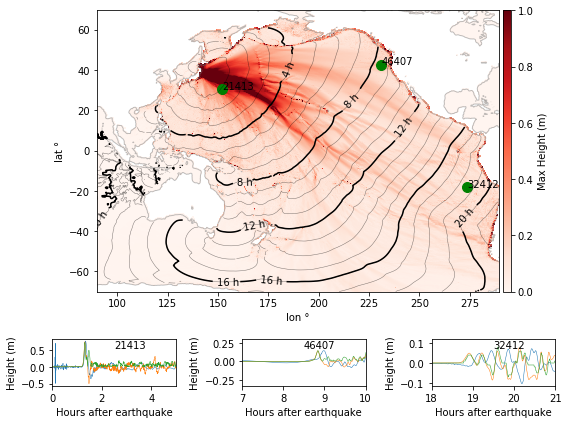

In [16]:
gs = gridspec.GridSpec(2, 3,
                       width_ratios=[1,1,1],
                       height_ratios=[6, 1])

f = plt.figure(figsize=(4*2,3*2))
ax1 = f.add_subplot(gs[0,:])
ax2 = f.add_subplot(gs[1,0])
ax3 = f.add_subplot(gs[1,1])
ax4 = f.add_subplot(gs[1,2])


p = ax1.pcolormesh(x[::s,::s],y[::s,::s],hmax_masked[::s,::s],vmax=1,vmin=0, cmap=plt.cm.Reds)
divider = make_axes_locatable(ax1)
ax1.scatter(dart_locations[:,0],dart_locations[:,1],color='green',marker='o', s=100)
for [lon,lat], dart in zip(dart_locations, darts_to_plot):
    ax1.annotate('%s'%dart, [lon,lat])
cax = divider.append_axes("right", size="2%", pad=0.05)
cbar = f.colorbar(p,cax)
cbar.set_label('Max Height (m)')

ax1.contour(x[::s,::s],y[::s,::s], bathymetry[::s,::s], [10], linewidths=1, alpha=0.5, colors='grey')
CS = ax1.contour(x[::s,::s],y[::s,::s],harrmasked[::s,::s]/60/60,np.arange(0,24,4),colors='k')
ax1.clabel(CS, inline=1, fontsize=10, fmt='%i h')
ax1.contour(x[::s,::s],y[::s,::s],harrmasked[::s,::s]/60/60,
            np.arange(0,24,1),colors='k', linewidths=0.5, alpha=0.5)

ax1.set_aspect(1)
ax1.set_xlabel('lon °')
ax1.set_ylabel('lat °')

for ax,dart in zip([ax2,ax3,ax4],darts_to_plot):
    print(ax,dart)
    ax.plot(darts[dart][:,0]*24, darts[dart][:,1],linewidth=0.5)
    ax.plot(np.array(nami[dart].time)/60/60, nami[dart].surface,linewidth=0.5)
    ax.plot(ewave['Minute']/60,ewave[str(dart)],linewidth=0.5)
    ax.set_xlim(ranges[dart][0],ranges[dart][1])
    ax.set_xlabel('Hours after earthquake')
    ax.set_ylabel('Height (m)')
    ax.annotate('%s'%dart, [0.5,0.8], xycoords='axes fraction')

plt.tight_layout()

In [17]:
f.savefig('figure.png',dpi=300)